<a href="https://colab.research.google.com/github/Tottoro932/Neural-networks/blob/main/Lab_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
Lab 2: MXNet Basic Classification

**Lab 2: MXNet Basic Classification**

In [2]:
!pip install mxnet

     |████████████████████████████████| 46.9 MB 46 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [3]:
# импорт библиотек
import mxnet as mx
from mxnet.gluon.data.vision import transforms

from mxnet import nd, gluon, autograd
from mxnet.gluon import nn

import pickle  # формат для выгрузки данных из памяти на диск и обратно

import numpy as np
import matplotlib.pyplot as plt   # для отображения графиков

# Select a fixed random seed for reproducibility
mx.random.seed(42)

In [4]:
# загрузили датасеты
train_fh = open('lego-simple-mx-train', 'rb') 
test_fh = open('lego-simple-mx-test', 'rb') 


In [5]:
# прочитали датасеты
train_data = pickle.load(train_fh) 
test_data = pickle.load(test_fh) 

In [6]:
# задали имена классов (10 штук)
class_names = ['2x3 Brick', '2x2 Brick', '1x3 Brick', '2x1 Brick', '1x1 Brick', '2x2 Macaroni', '2x2 Curved End', 'Cog 16 Tooth', '1x2 Handles', '1x2 Grill'] 
# нормализуем изображения
transformer = transforms.Compose([ 
    transforms.ToTensor(), 
    transforms.Normalize(0.13, 0.31)]) 


In [7]:
train_data = train_data.transform_first(transformer) 
test_data = test_data.transform_first(transformer) 


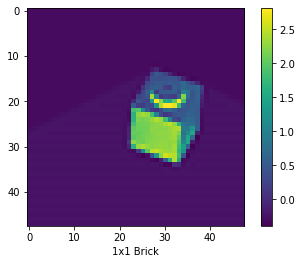

In [8]:
train_image_no = 0  # задаем номер картинки, которую хотим вывести
 
images_data, label_data = train_data[train_image_no] 
plt.figure() 
plt.imshow(images_data.reshape((48,48)).asnumpy()) # выводим картинку на экран, 48 на 48 пикселей
plt.colorbar() 
plt.xlabel(class_names[label_data]) 
plt.show() 


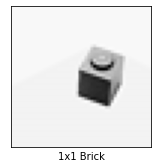

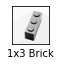

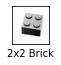

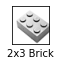

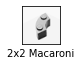

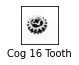

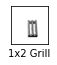

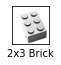

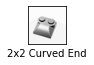

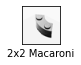

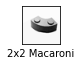

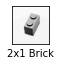

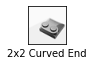

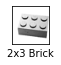

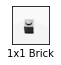

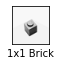

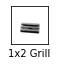

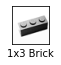

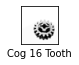

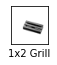

In [9]:
# хотим в табличном виде (15 на 15) показать состав датасета
plt.figure(figsize=(15,15)) # plt - библиотека для рисование графиков
for i in range(20): 
   images_data, label_data = train_data[i] 
   plt.subplot(5,5,i+1) 
   plt.xticks([]) 
   plt.yticks([]) 
   plt.imshow(images_data.reshape((48,48)).asnumpy(), cmap=plt.cm.binary) 
   plt.xlabel(class_names[label_data]) 
   plt.show() 


In [10]:
# создаем модель нейронной сети из 3 последовательных слоев
net = nn.HybridSequential(prefix='MLP_') 
with net.name_scope(): 
   net.add( 
     nn.Flatten(), # переводим в векторную форму
     nn.Dense(128, activation='relu'), # первый слой: 128 нейронов, функция активации (чтобы уйти от линейной зависимости)
     nn.Dense(64, activation='relu'), # второй слой: 128 нейронов, relu: 0 - отриц.при аргументах <0 и само значение при аргументах >0
     nn.Dense(10, activation=None)     # второй слой: 128 нейронов, не содержит активации
   ) 
   # nn - функция mxnet, отвечает за создание нейронных сетей


In [11]:
batch_size = 34 # кол-во картинок, которые мы пропускаем за один раз через сеть во время обучения
train_loader = mx.gluon.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)

In [12]:
ctx = mx.gpu(0) if mx.context.num_gpus() > 0 else mx.cpu(0) 
net.initialize(mx.init.Xavier(), ctx=ctx)

In [13]:
ctx  # видим, что работа идет на cpu
# можно изменить в "среде выполения"

cpu(0)

In [14]:
trainer = gluon.Trainer(  # trainer проводит оптимизацию параметров
  params=net.collect_params(), # возвращает параметры net (количество узлов матрицы коэффициентов)
  optimizer='sgd', 
  optimizer_params={'learning_rate': 0.04}, # задали скорость тренировки 0.04
) 

In [15]:
# метрики для отслеживания обучения сети (на сколько хорошо обучается)
metric = mx.metric.Accuracy() # accuracy - точность
loss_function = gluon.loss.SoftmaxCrossEntropyLoss() # функция потерь (на сколько каждая картинка отличается от ожидаемого результата)


In [16]:
# начинаем обучение
num_epochs = 10 # количество эпох (10 раз просматриваем датасет перед тем как завершить обучение)
history = [] 
 
for epoch in range(num_epochs):    # цикл по эпохам
  for inputs, labels in train_loader:   # train_loader - подгрузка данных из датасета порциями
    # Possibly copy inputs and labels to the GPU 
    inputs = inputs.as_in_context(ctx) 
    labels = labels.as_in_context(ctx) 
 
    # Forward pass 
    with autograd.record(): 
      outputs = net(inputs) 
      loss = loss_function(outputs, labels) 
 
    # Backpropagation   # оцениваем функцию потерь и делаем корректировку
    loss.backward() 
    metric.update(labels, outputs) # обновляем метрику (следим за качеством на каждом шаге)
 
    # Update 
    trainer.step(batch_size=inputs.shape[0]) # trainer - следит за состоянием тренировки (обновляем каждый раз)
 
  # Print the evaluation metric and reset it for the next epoch 
  name, acc = metric.get() # точность рассчитывается через метрику
  history.insert(epoch,acc) # на каждом шаге вставляем в массив номер эпохи и текущее значение точности
  print('.', end='') 
  metric.reset() 
 
print('[Done]')

..........[Done]


Text(0.5, 0, 'Epoch')

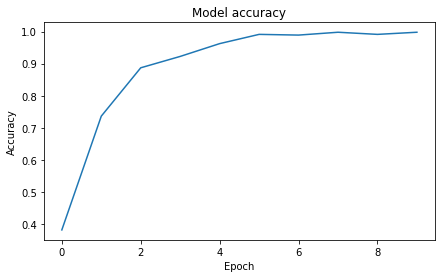

In [17]:
plt.figure(figsize=(7, 4)) 
plt.plot(history) # массив с предыдущего шага
plt.title('Model accuracy') 
plt.ylabel('Accuracy') 
plt.xlabel('Epoch') 
# как менялась точность с количеством эпох 
# с 6 эпохи точность почти не менялась

In [18]:
# из тестовых данных подгружаем результаты для проверки качества нашей сети
test_loader = mx.gluon.data.DataLoader(test_data, shuffle=False, batch_size=batch_size) 


In [20]:
# повторям тот же процесс что и при обучении
metric = mx.metric.Accuracy() 
for inputs, labels in test_loader: 
  # Possibly copy inputs and labels to the GPU 
  inputs = inputs.as_in_context(ctx) 
  labels = labels.as_in_context(ctx) 
  metric.update(labels, net(inputs)) 
 
print('Validation: {} = {}'.format(*metric.get()))
# на выходе получаем точность результатов

Validation: accuracy = 0.96


In [21]:
# Function to display the image: 
def plot_image(predictions_array, true_label, img): 
  plt.xticks([]) 
  plt.yticks([]) 
  plt.imshow(img.reshape((48,48)).asnumpy(), cmap=plt.cm.binary) 
  predicted_label = np.argmax(predictions_array) 
  

  if predicted_label == true_label: 
    color = 'green' 
  else: 
    color = 'red' 
   

  # Print a label with 'predicted class', 'probability %', 'actual class' 
  plt.xlabel("{} [{:2.0f}] ({})".format( 

    class_names[predicted_label], 
    np.max(predictions_array), 
    class_names[true_label]), 

                                  color=color) 
 
# Function to display the prediction results in a graph: 
def plot_value_array(predictions_array, true_label): 
  plt.xticks(range(10)) 
  plt.yticks([]) 
  plot = plt.bar(range(10), predictions_array, color="#777777") 
  predicted_label = np.argmax(predictions_array) 
  plot[predicted_label].set_color('red') 
  plot[true_label].set_color('green')

In [22]:
prediction_image_number = 1  # грузим из тестовых данных элемент с таким номером

In [23]:
prediction_image, prediction_label = test_data[prediction_image_number] 
predictions_single = net(prediction_image) 
predictions_single 
# выдает вектор значений с последнего слоя


[[  2.2906933   9.670974    0.8310373  -2.539004  -11.896596    1.4089143
    4.3669434  -4.155239   -7.0252275  -8.972304 ]]
<NDArray 1x10 @cpu(0)>

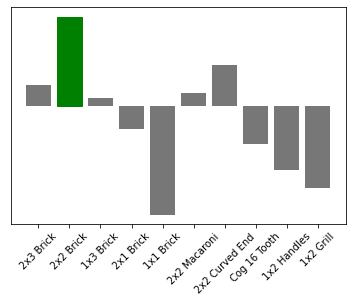

In [24]:
# перевели этот вектор в наши классы (сопоставили циферьки с классами и нашли тот класс, на который больше всего похоже изображение)
plot_value_array(predictions_single[0].asnumpy(), prediction_label) 
plt.xticks(range(10), class_names, rotation=45) 
plt.show()

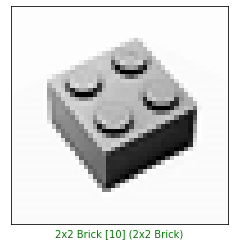

In [25]:
plot_image(predictions_single[0].asnumpy(), prediction_label, prediction_image) 
# вывели эту картинку (действительно верно определен класс) 

In [26]:
# хотим прогнать все картинки (не все, а 10)
predictions = [] 
test_labels = [] 
 
for i in test_data: 
  pred_image, pred_label = i 
  p = net(pred_image) 
  predictions.append(p) 
  test_labels.append(pred_label) 
 

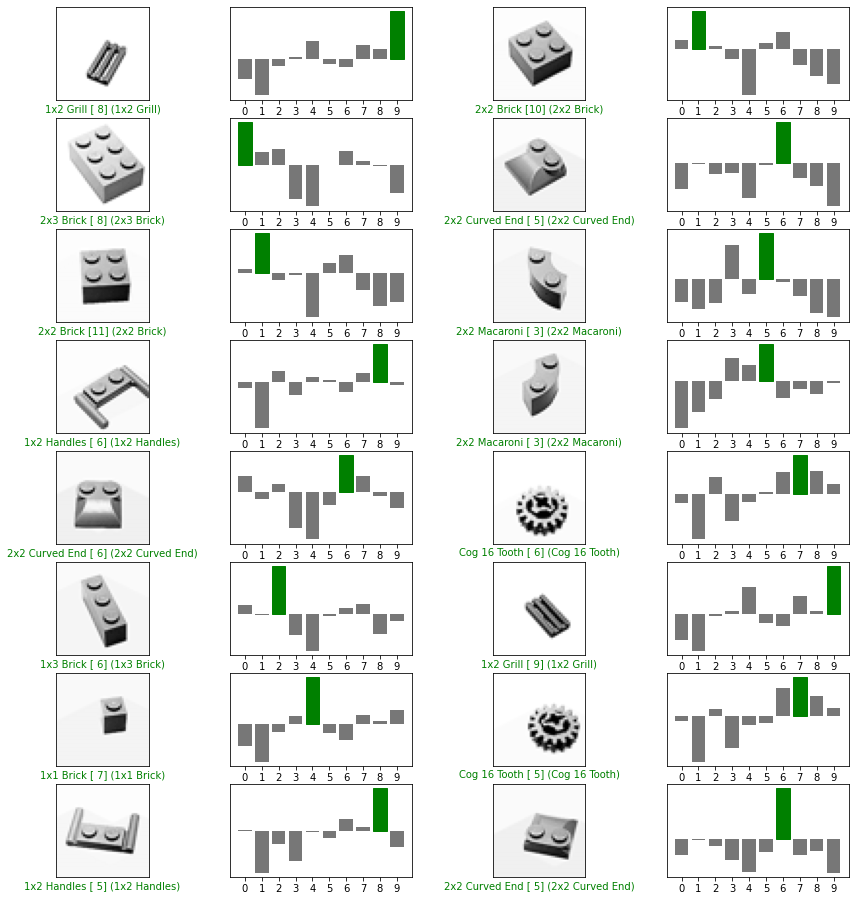

In [27]:
num_rows = 8 
num_cols = 2 
num_images = num_rows*num_cols 
plt.figure(figsize=(15, 16)) 
 
for i in range(num_images): 
  plt.subplot(num_rows, 2*num_cols, 2*i+1) 
  plot_image(predictions[i].asnumpy(), test_data[i][1], test_data[i][0]) 
  plt.subplot(num_rows, 2*num_cols, 2*i+2) 
  plot_value_array(predictions[i][0].asnumpy(), test_data[i][1]) 
 
plt.show()